<a href="https://colab.research.google.com/github/aayushrai/Reinforcement_learning/blob/master/Deep_Reinforcement_Learning_with_Open_AI_Gym(keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# imports
from collections import deque
import gym
import numpy as np
import random
import keras
import cv2
from keras.models import load_model, Sequential
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.layers.core import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

Using TensorFlow backend.


In [0]:
# memory for store experience
class ReplayBuffer:
    """Constructs a buffer object that stores the past moves
    and samples a set of subsamples"""

    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, s, a, r, d, s2):
        """Add an experience to the buffer"""
        # S represents current state, a is action,
        # r is reward, d is whether it is the end, 
        # and s2 is next state
        experience = (s, a, r, d, s2)
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        """Samples a total of elements equal to batch_size from buffer
        if buffer contains enough elements. Otherwise return all elements"""

        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        # Maps each experience in batch in batches of states, actions, rewards
        # and new states
        s_batch, a_batch, r_batch, d_batch, s2_batch = list(map(np.array, list(zip(*batch))))

        return s_batch, a_batch, r_batch, d_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

In [0]:
DECAY_RATE = 0.99
BUFFER_SIZE = 40000
MINIBATCH_SIZE = 64
TOT_FRAME = 3000000
EPSILON_DECAY = 1000000
MIN_OBSERVATION = 3000
FINAL_EPSILON = 0.09
INITIAL_EPSILON = 0.8
NUM_ACTIONS = 6
TAU = 0.01
# Number of frames to throw into network
NUM_FRAMES = 3

In [0]:
class DeepQ(object):
    """Constructs the desired deep q learning network"""
    def __init__(self):
        self.construct_q_network()

    def construct_q_network(self):
        # Uses the network architecture found in DeepMind paper
        self.model = Sequential()
        self.model.add(Convolution2D(32, 8, 8, subsample=(4, 4), input_shape=(84, 84, NUM_FRAMES)))
        self.model.add(Activation('relu'))
        self.model.add(Convolution2D(64, 4, 4, subsample=(2, 2)))
        self.model.add(Activation('relu'))
        self.model.add(Convolution2D(64, 3, 3))
        self.model.add(Activation('relu'))
        self.model.add(Flatten())
        self.model.add(Dense(512))
        self.model.add(Activation('relu'))
        self.model.add(Dense(NUM_ACTIONS))
        self.model.compile(loss='mse', optimizer=Adam(lr=0.00001))

        # Creates a target network as described in DeepMind paper
        self.target_model = Sequential()
        self.target_model.add(Convolution2D(32, 8, 8, subsample=(4, 4), input_shape=(84, 84, NUM_FRAMES)))
        self.target_model.add(Activation('relu'))
        self.target_model.add(Convolution2D(64, 4, 4, subsample=(2, 2)))
        self.target_model.add(Activation('relu'))
        self.target_model.add(Convolution2D(64, 3, 3))
        self.target_model.add(Activation('relu'))
        self.target_model.add(Flatten())
        self.target_model.add(Dense(512))
        self.model.add(Activation('relu'))
        self.target_model.add(Dense(NUM_ACTIONS))
        self.target_model.compile(loss='mse', optimizer=Adam(lr=0.00001))
        self.target_model.set_weights(self.model.get_weights())
    def save_network(self, path):
        # Saves model at specified path as h5 file
        self.model.save(path)
        print("Successfully saved network.")

    def load_network(self, path):
        self.model = load_model(path)
        print("Succesfully loaded network.")

    def target_train(self):
        model_weights = self.model.get_weights()
        target_model_weights = self.target_model.get_weights()
        for i in range(len(model_weights)):
            target_model_weights[i] = TAU * model_weights[i] + (1 - TAU) * target_model_weights[i]
        self.target_model.set_weights(target_model_weights)

    def predict_movement(self, data, epsilon):
        """Predict movement of game controler where is epsilon
        probability randomly move."""
        q_actions = self.model.predict(data.reshape(1, 84, 84, NUM_FRAMES), batch_size = 1)
        opt_policy = np.argmax(q_actions)
        rand_val = np.random.random()
        if rand_val < epsilon:
            opt_policy = np.random.randint(0, NUM_ACTIONS)
        return opt_policy, q_actions[0, opt_policy]
    
    def predict_movement(self, data, epsilon):
        """Predict movement of game controler where is epsilon
        probability randomly move."""
        q_actions = self.model.predict(data.reshape(1, 84, 84, NUM_FRAMES), batch_size = 1)
        opt_policy = np.argmax(q_actions)
        rand_val = np.random.random()
        if rand_val < epsilon:
            opt_policy = np.random.randint(0, NUM_ACTIONS)
        return opt_policy, q_actions[0, opt_policy]

    def train(self, s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num):
        """Trains network to fit given parameters"""
        batch_size = s_batch.shape[0]
        targets = np.zeros((batch_size, NUM_ACTIONS))

        for i in range(batch_size):
            targets[i] = self.model.predict(s_batch[i].reshape(1, 84, 84, NUM_FRAMES), batch_size = 1)
            fut_action = self.target_model.predict(s2_batch[i].reshape(1, 84, 84, NUM_FRAMES), batch_size = 1)
            targets[i, a_batch[i]] = r_batch[i]
            if d_batch[i] == False:
                targets[i, a_batch[i]] += DECAY_RATE * np.max(fut_action)

        loss = self.model.train_on_batch(s_batch, targets)

        # Print the loss every 10 iterations.
        if observation_num % 10 == 0:
            print("We had a loss equal to ", loss)

    def save_network(self, path):
        # Saves model at specified path as h5 file
        self.model.save(path)
        print("Successfully saved network.")

    def load_network(self, path):
        self.model = load_model(path)
        print("Succesfully loaded network.")

    def target_train(self):
        model_weights = self.model.get_weights()
        target_model_weights = self.target_model.get_weights()
        for i in range(len(model_weights)):
            target_model_weights[i] = TAU * model_weights[i] + (1 - TAU) * target_model_weights[i]
        self.target_model.set_weights(target_model_weights)


In [0]:
class SpaceInvader(object):

    def __init__(self, mode):
        self.env = gym.make('SpaceInvaders-v0')
        self.env.reset()
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)

        # Construct appropriate network based on flags
        if mode == "DDQN":
            self.deep_q = DeepQ()
        elif mode == "DQN":
            self.deep_q = DuelQ()

        # A buffer that keeps the last 3 images
        self.process_buffer = []
        # Initialize buffer with the first frame
        s1, r1, _, _ = self.env.step(0)
        s2, r2, _, _ = self.env.step(0)
        s3, r3, _, _ = self.env.step(0)
        self.process_buffer = [s1, s2, s3]

    def load_network(self, path):
        self.deep_q.load_network(path)

    def convert_process_buffer(self):
        """Converts the list of NUM_FRAMES images in the process buffer
        into one training sample"""
        black_buffer = [cv2.resize(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), (84, 90)) for x in self.process_buffer]
        black_buffer = [x[1:85, :, np.newaxis] for x in black_buffer]
        return np.concatenate(black_buffer, axis=2)

    def train(self, num_frames):
        observation_num = 0
        curr_state = self.convert_process_buffer()
        epsilon = INITIAL_EPSILON
        alive_frame = 0
        total_reward = 0

        while observation_num < num_frames:
            print("Iteration No:",observation_num)
            if observation_num % 1000 == 999:
                print(("Executing loop %d" %observation_num))

            # Slowly decay the learning rate
            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON-FINAL_EPSILON)/EPSILON_DECAY

            initial_state = self.convert_process_buffer()
            self.process_buffer = []

            predict_movement, predict_q_value = self.deep_q.predict_movement(curr_state, epsilon)

            reward, done = 0, False
            for i in range(NUM_FRAMES):
                temp_observation, temp_reward, temp_done, _ = self.env.step(predict_movement)
                reward += temp_reward
                self.process_buffer.append(temp_observation)
                done = done | temp_done

            if observation_num % 10 == 0:
                print("We predicted a q value of ", predict_q_value)

            if done:
                print("Lived with maximum time ", alive_frame)
                print("Earned a total of reward equal to ", total_reward)
                self.env.reset()
                alive_frame = 0
                total_reward = 0

            new_state = self.convert_process_buffer()
            self.replay_buffer.add(initial_state, predict_movement, reward, done, new_state)
            total_reward += reward

            if self.replay_buffer.size() > MIN_OBSERVATION:
                s_batch, a_batch, r_batch, d_batch, s2_batch = self.replay_buffer.sample(MINIBATCH_SIZE)
                self.deep_q.train(s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num)
                self.deep_q.target_train()

            # Save the network every 100000 iterations
            if observation_num % 10000 == 9999:
                print("Saving Network")
                self.deep_q.save_network("saved.h5")

            alive_frame += 1
            observation_num += 1

    def simulate(self, path = "", save = False):
        """Simulates game"""
        done = False
        tot_award = 0
        if save:
            self.env.monitor.start(path, force=True)
        self.env.reset()
        self.env.render()
        while not done:
            state = self.convert_process_buffer()
            predict_movement = self.deep_q.predict_movement(state, 0)[0]
            self.env.render()
            observation, reward, done, _ = self.env.step(predict_movement)
            tot_award += reward
            self.process_buffer.append(observation)
            self.process_buffer = self.process_buffer[1:]
        if save:
            self.env.monitor.close()
    def simulate2(self, path = "", save = False):
        """Simulates game"""
        done = False
        tot_award = 0
        if save:
          self.env.monitor.start(path, force=True)
        self.env.reset()
        self.show_state(self.env)
        while not done:
            state = self.convert_process_buffer()
            predict_movement = self.deep_q.predict_movement(state, 0)[0]
            self.show_state(self.env)
            observation, reward, done, _ = self.env.step(predict_movement)
            tot_award += reward
            self.process_buffer.append(observation)
            self.process_buffer = self.process_buffer[1:]
        if save:
            self.env.monitor.close()

    def show_state(self,env, step=0, info=""):
        plt.figure(5,figsize=(10,10))
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())

    def calculate_mean(self, num_samples = 100):
        reward_list = []
        print("Printing scores of each trial")
        for i in range(num_samples):
            done = False
            tot_award = 0
            self.env.reset()
            while not done:
                state = self.convert_process_buffer()
                predict_movement = self.deep_q.predict_movement(state, 0.0)[0]
                observation, reward, done, _ = self.env.step(predict_movement)
                tot_award += reward
                self.process_buffer.append(observation)
                self.process_buffer = self.process_buffer[1:]
            print(tot_award)
            reward_list.append(tot_award)
        return np.mean(reward_list), np.std(reward_list)

In [23]:
game_instance = SpaceInvader("DDQN")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=(84, 84, 3..., strides=(4, 4))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=(84, 84, 3..., strides=(4, 4))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2))`
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

In [24]:
 NUM_FRAME = 000
 game_instance.train(NUM_FRAME)

Iteration No: 0
We predicted a q value of  4.275073
Iteration No: 1
Iteration No: 2
Iteration No: 3
Iteration No: 4
Iteration No: 5
Iteration No: 6
Iteration No: 7
Iteration No: 8
Iteration No: 9
Iteration No: 10
We predicted a q value of  0.0
Iteration No: 11
Iteration No: 12
Iteration No: 13
Iteration No: 14
Iteration No: 15
Iteration No: 16
Iteration No: 17
Iteration No: 18
Iteration No: 19
Iteration No: 20
We predicted a q value of  0.0
Iteration No: 21
Iteration No: 22
Iteration No: 23
Iteration No: 24
Iteration No: 25
Iteration No: 26
Iteration No: 27
Iteration No: 28
Iteration No: 29
Iteration No: 30
We predicted a q value of  4.275073
Iteration No: 31
Iteration No: 32
Iteration No: 33
Iteration No: 34
Iteration No: 35
Iteration No: 36
Iteration No: 37
Iteration No: 38
Iteration No: 39
Iteration No: 40
We predicted a q value of  4.275073
Iteration No: 41
Iteration No: 42
Iteration No: 43
Iteration No: 44
Iteration No: 45
Iteration No: 46
Iteration No: 47
Iteration No: 48
Iterati

In [0]:
game_instance.load_network("/content/saved.h5")

In [0]:
stat = game_instance.calculate_mean()
print("Game Statistics")
print(stat)

In [0]:
#game_instance.simulate2(path="n.mp4", save=True)

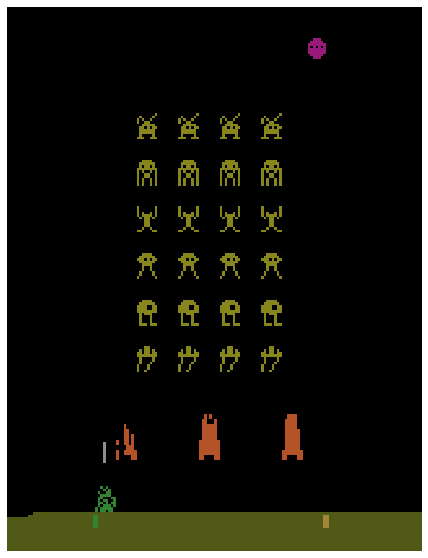

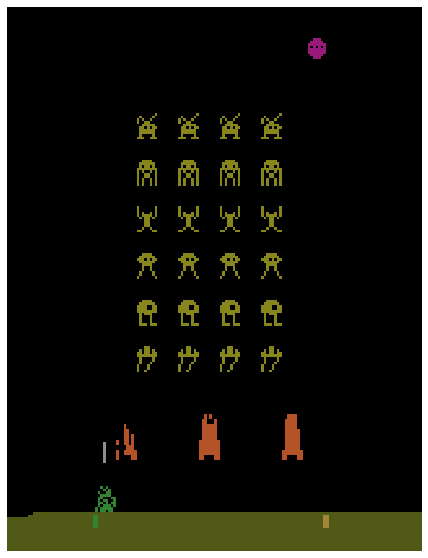

In [25]:
game_instance.simulate2()